# General Overview

Dataset Resources: [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)

[Kaggle Link](https://www.kaggle.com/pavan2029/diabetic-data)

**Objective:**
Hospital readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely. Hospital readmissions of diabetic patients are expensive as hospitals face penalties if their readmission rate is higher than expected and reflects the inadequacies in health care system. For these reasons, it is important for the hospitals to improve focus on reducing readmission rates. Identify the key factors that influence readmission for diabetes and to predict the probability of patient readmission. 

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.*

### Import Libraries

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

sns.set(style='darkgrid')
%matplotlib inline

### Import Dataset

In [90]:
pd.read_csv('diabetic_data.zip').head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [91]:
# csv contains "?" for missing values. We replace it with NaN
data = pd.read_csv('diabetic_data.zip', na_values=["?"])
df= data.copy()
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Import Features Dataset
Descriptions of the features:
https://www.hindawi.com/journals/bmri/2014/781670/tab1/

In [92]:
features = pd.read_csv('features.csv',index_col='Unnamed: 0')
info = lambda attribute:print(f"{attribute.upper()} : {features[features['Feature']==attribute]['Description'].values[0]}\n")
features.head()

,Feature,Type,Description
0,encounter_id,Numeric,Unique identifier of an encounter
1,patient_nbr,Numeric,Unique identifier of a patient
2,race,Nominal,"Values: Caucasian, Asian, African American, Hi..."
3,gender,Nominal,"Values: male, female, and unknown/invalid"
4,age,Nominal,"Grouped in 10-year intervals: 0, 10), 10, 20),..."


In [93]:
info('encounter_id')

ENCOUNTER_ID : Unique identifier of an encounter



### Check Duplicates

In [94]:
df.duplicated().value_counts()
# df = df.drop_duplicates()

False    101766
dtype: int64

> no duplicates detected!

### Descriptive Analysis

In [95]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(df).sort_values(by='Nulls', ascending=False))

Data shape: (101766, 50)
___________________________
Data Types:
object    37
int64     13
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
weight,object,3197,10,98569,NaN,NaN
medical_specialty,object,51817,73,49949,NaN,NaN
payer_code,object,61510,18,40256,NaN,NaN
race,object,99493,6,2273,NaN,NaN
diag_3,object,100343,790,1423,NaN,NaN
diag_2,object,101408,749,358,NaN,NaN
diag_1,object,101745,717,21,NaN,NaN
nateglinide,object,101766,4,0,Down,Up
num_lab_procedures,int64,101766,118,0,1,132
num_medications,int64,101766,75,0,1,81


* 'citoglipton' and 'examide' features that the number of uniques is 1 are droped.
* all values of 'encounter_id' column are unique. It has to be droped.

In [96]:
df = df.drop(['citoglipton','examide','encounter_id'],axis=1)

### FOCUS ON "Gender"

In [97]:
df.gender.value_counts(dropna=False)

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

> We regard the observations of "Unknown/Invalid" gender as null values and drop them.

In [98]:
gender_index = df[df.gender == 'Unknown/Invalid'].index
df = df.drop(gender_index, axis=0)

In [99]:
# confirm removal
df.gender.value_counts(dropna=False)

Female    54708
Male      47055
Name: gender, dtype: int64

### FOCUS ON "readmitted"

In [100]:
df.readmitted.value_counts(dropna=False)

NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

> Patients readmitted to the hospital within and after 30 days will be combined into one column, because these patients ultimately returned.

In [101]:
df = df.replace(['<30', '>30'], 'YES')

### FOCUS  ON " patient_nbr "

In [102]:
info('patient_nbr')

PATIENT_NBR : Unique identifier of a patient



In [103]:
df['patient_nbr'].duplicated().value_counts(dropna=False)

False    71515
True     30248
Name: patient_nbr, dtype: int64

* we can think of 'patient_nbr' as the id number of each patient.
* It turned out that the dataset is the data of 71515 unique patients.
* Some patients visited the hospital multiple times for treatment so to avoid over-representing any particular individual, only the first encounter with a patient will be used / kept in this dataset.

In [104]:
# total unique patients
len(df.patient_nbr), df.patient_nbr.nunique()

(101763, 71515)

In [17]:
# locate number of patient visits using patient_id
df.patient_nbr.value_counts()

88785891     40
43140906     28
88227540     23
1660293      23
23199021     23
             ..
71081460      1
30060018      1
67443444      1
141344240     1
93251151      1
Name: patient_nbr, Length: 71515, dtype: int64

In [18]:
# keep only one record for each patient, the first visit
df = df.drop_duplicates(['patient_nbr'], keep='first')
df.shape

(71515, 47)

In [19]:
df.patient_nbr.nunique()

71515

* Since patient_nbr is unique, it is no longer needed.

In [20]:
df = df.drop('patient_nbr', axis=1)

### Dropping irrelevant columns

In [21]:
 def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [22]:
# columns with missing values
null_values(df)

,Missing_Records,Percentage (%)
weight,68662,96.010627
medical_specialty,34475,48.206670
payer_code,31042,43.406278
race,1946,2.721107
diag_3,1225,1.712927
diag_2,294,0.411103
diag_1,11,0.015381


In [23]:
for i in ['weight','medical_specialty','payer_code']: info(i)

WEIGHT : Weight in pounds.

MEDICAL_SPECIALTY : Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon

PAYER_CODE : Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay



* The majority of patients do not have a weight listed so this column can be dropped. 
* Medical specialty and payer code are also missing for about half of the patients. 
* We do not need to know how the patients paid for their treatments.
* we do not have enough information to figure out which medical unit they went to.

In [106]:
df = df.drop(['weight','medical_specialty','payer_code'], axis=1)

In [25]:
summary(df).sort_values(by='Uniques', ascending=False)[:20]

Data shape: (71515, 43)
___________________________
Data Types:
object    32
int64     11
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
diag_3,object,70290,759,1225,NaN,NaN
diag_2,object,71221,726,294,NaN,NaN
diag_1,object,71504,697,11,NaN,NaN
num_lab_procedures,int64,71515,116,0,1,132
num_medications,int64,71515,75,0,1,81
number_outpatient,int64,71515,33,0,0,42
discharge_disposition_id,int64,71515,26,0,1,28
number_emergency,int64,71515,18,0,0,42
admission_source_id,int64,71515,17,0,1,25
number_diagnoses,int64,71515,16,0,1,16


In [26]:
for i in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']: info(i)

ADMISSION_TYPE_ID : Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

DISCHARGE_DISPOSITION_ID : Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available

ADMISSION_SOURCE_ID : Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital



* We dont need 'admission_type_id', 'discharge_disposition_id', 'admission_source_id' columns

In [27]:
# drop columns
drop_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df = df.drop(drop_cols, axis=1)

### Handling Missing Values

In [107]:
null_values(df)

,Missing_Records,Percentage (%)
race,2271,2.231656
diag_3,1423,1.398347
diag_2,358,0.351798
diag_1,21,0.020636


In [29]:
df.race.value_counts(dropna=False)

Caucasian          53491
AfricanAmerican    12887
NaN                 1946
Hispanic            1517
Other               1177
Asian                497
Name: race, dtype: int64

* Since there is no way to know the race of the patient using existing information, the best option is to remove those rows.

In [30]:
df = df.dropna(axis=0, subset=['race'])
null_values(df)

,Missing_Records,Percentage (%)
diag_3,1158,1.664534
diag_2,275,0.395291
diag_1,10,0.014374


In [31]:
for i in ['diag_1', 'diag_2', 'diag_3']: info(i)

DIAG_1 : The primary diagnosis (coded as first three digits of ICD9); 848 distinct values

DIAG_2 : Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values

DIAG_3 : Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values



* You can reach the extensive diagnosis description on this website by querying with the ICD9 code:
http://icd9.chrisendres.com/

Now, we are down to three columns with missing information: diagnosis 1, 2, and 3. 
* Diagnosis 1 is described as the primary diagnosis made during the patient's visit while diagnosis 2 is the second and 3 is an any additional diagnoses made after that. 
* Looking at the patients' rows that are missing a primary diagnosis, most of them have a second diagnosis or even a third. 
* Since it doesn't make sense to have a second (or third) but not a primary diagnosis, we will remove these columns from the dataset.

In [32]:
info('number_diagnoses')

NUMBER_DIAGNOSES : Number of diagnoses entered to the system



In [33]:
df[['diag_1', 'diag_2', 'diag_3','number_diagnoses']][df.diag_1.isnull() & df.diag_2.notnull() & df.diag_3.notnull() & df.number_diagnoses.notnull()]

,diag_1,diag_2,diag_3,number_diagnoses
518,NaN,780,997,4
1267,NaN,250.82,401,5
1488,NaN,276,594,8
3197,NaN,250.01,428,7
37693,NaN,780,295,9
57058,NaN,V63,414,6
57737,NaN,276,V08,8
60314,NaN,427,486,8
86018,NaN,250.02,438,4


The number of diagnoses column shows the total number of conditions a patient is diagnosed with. Only the first three are recorded, so those that are missing the first diagnosis but still a second or third are in error.

In [34]:
# remove rows where diagnosis 1 is missing
df = df.dropna(axis=0, subset=['diag_1'])

There are two remaining diagnosis columns with missing values. Each number correlates to a specific condition so if there is a missing value, then it is likely that the patient only has one diagnosed condition. The number of diagnoses column lists the total number of diagnosed conditions. When looking at all three diagnosis columns, if the number is one, then diagnosis 2 and 3 can be filled in with a 0 to show that there is no additional diagnosis. If diagnosis 2 or 3 is missing a value and the number of diagnoses is greater than one, then some diagnoses were not recorded and the rows should be removed.

In [35]:
null_values(df)

,Missing_Records,Percentage (%)
diag_3,1157,1.663336
diag_2,274,0.393910


In [36]:
df[['diag_1','diag_2', 'diag_3','number_diagnoses']][df.diag_2.isnull() & (df.diag_3.notnull()|(df.number_diagnoses > 1))]

,diag_1,diag_2,diag_3,number_diagnoses
1657,604,NaN,250.6,6
17116,227,NaN,401,6
18415,435,NaN,401,9
20289,402,NaN,425,9
24250,998,NaN,250,5
...,...,...,...,...
76321,414,NaN,250,3
86140,491,NaN,NaN,3
87788,562,NaN,250,4
99621,428,NaN,428,8


In [37]:
# remove rows where diagnosis 2 is missing and number of diagnoses is greater than 1
diag_2_indexes = df[df.diag_2.isnull() & (df.diag_3.notnull()|(df.number_diagnoses > 1))].index
df = df.drop(index = diag_2_indexes, axis=0)

In [38]:
null_values(df)

,Missing_Records,Percentage (%)
diag_3,1116,1.606379
diag_2,188,0.270609


Diagnosis 3 is the last column left with unaccounted missing values. Since some patients have 1 or 2 diagnosed conditions, the diagnosis 3 column is left intentionally blank. The goal here is to remove the rows that have a diagnoses number greater than two.

In [39]:
# list of affected rows
df[['diag_1','diag_2', 'diag_3', 'number_diagnoses']][df.diag_3.isnull() & (df.number_diagnoses > 2)]

,diag_1,diag_2,diag_3,number_diagnoses
339,722,729,NaN,3
5644,250.7,440,NaN,5
17472,820,599,NaN,9
25366,584,202,NaN,5
25391,807,276,NaN,5
...,...,...,...,...
94739,780,293,NaN,8
97071,493,250.01,NaN,5
97437,433,599,NaN,8
97578,574,552,NaN,8


In [40]:
# remove rows with missing diagnosis 3 and number of diagnoses is greater than 2
diag_3_indexes = df[(df.diag_3.isnull()) & (df.number_diagnoses > 2)].index
df = df.drop(index=diag_3_indexes, axis=0)

In [41]:
null_values(df)

,Missing_Records,Percentage (%)
diag_3,1031,1.485848
diag_2,188,0.270940


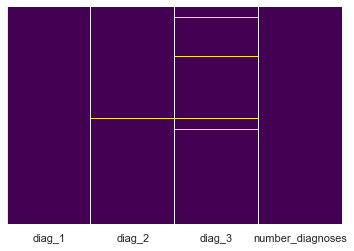

In [42]:
sns.heatmap(df[['diag_1','diag_2', 'diag_3','number_diagnoses']].isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [43]:
# replace NaN with None in diagnosis 2 and 3 to show there is no additional diagnosis
df.fillna('None', inplace=True)

In [44]:
# confirm there are no more NaN values
null_values(df)

,Missing_Records,Percentage (%)


### Grouping Diagnosis Codes

In [45]:
summary(df[['diag_1','diag_2', 'diag_3']])

Data shape: (69388, 3)
___________________________
Data Types:
object    3
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
diag_1,object,69388,692,0,10.0,V71
diag_2,object,69388,722,0,11.0,V86
diag_3,object,69388,756,0,110.0,V86


* 'diag_1','diag_2' and 'diag_3' columns contain codes for the types of conditions patients are diagnosed with. 
* There are too much unique codes throughout this dataset.
* We can group the related icd9 diagnosis codes among themselves. In this way, we use categorical group names instead of numerical codes.
* The grouping is based on the research paper table (https://www.hindawi.com/journals/bmri/2014/781670/tab2/)
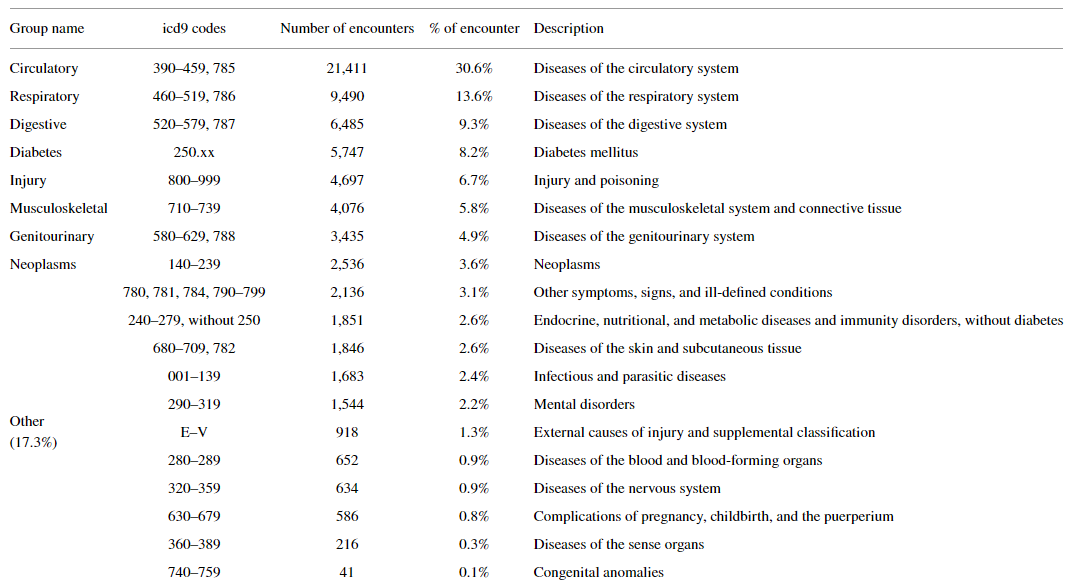

**Group Names**

    1-Circulatory
    2-Respiratory
    3-Digestive
    4-Diabetes
    5-Injury
    6-Musculoskeletal
    7-Genitourinary
    8-Neoplasms
    9-Other

In [46]:
# Circulatory
codes =[str(i) for i in list(range(390,460)) + [785]]
df = df.replace(codes, 'Circulatory')

In [47]:
# Respiratory
codes =[str(i) for i in list(range(460,520)) + [786]]
df = df.replace(codes, 'Respiratory')

In [48]:
# Digestive
codes =[str(i) for i in list(range(520,580)) + [787]]
df = df.replace(codes, 'Digestive')

In [49]:
# Diabetes
df = df.replace(regex=r'^250.*', value='Diabetes')

In [50]:
# Injury
codes =[str(i) for i in range(800,1000)]
df = df.replace(codes, 'Injury')

In [51]:
# Musculoskeletal
codes =[str(i) for i in range(710,740)]
df = df.replace(codes, 'Musculoskeletal')

In [52]:
# Genitourinary
codes =[str(i) for i in list(range(580,630)) + [788]]
df = df.replace(codes, 'Genitourinary')

In [53]:
# Neoplasms
codes =[str(i) for i in range(140,240)]
df = df.replace(codes, 'Neoplasms')

In [54]:
# Other
df = df.replace(regex=r'^[E,V].*', value='Other')

codes =[str(i) for i in range(0,1000)]
df = df.replace(codes, 'Other')

In [55]:
df[['diag_1', 'diag_2', 'diag_3']].head()

,diag_1,diag_2,diag_3
0,Diabetes,None,None
1,Other,Diabetes,Other
2,Other,Diabetes,Other
3,Other,Diabetes,Circulatory
4,Neoplasms,Neoplasms,Diabetes


In [56]:
# Unique Values of Each Features:
for i in df[['diag_1', 'diag_2', 'diag_3']]:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

diag_1:
['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 'Musculoskeletal', 'Neoplasms', 'Other', 'Respiratory']

diag_2:
['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 'Musculoskeletal', 'Neoplasms', 'None', 'Other', 'Respiratory']

diag_3:
['365.44', 'Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 'Musculoskeletal', 'Neoplasms', 'None', 'Other', 'Respiratory']



In [57]:
# need to add 365.44 to Other
df = df.replace('365.44', 'Other') 

### Analysis of Diagnosis

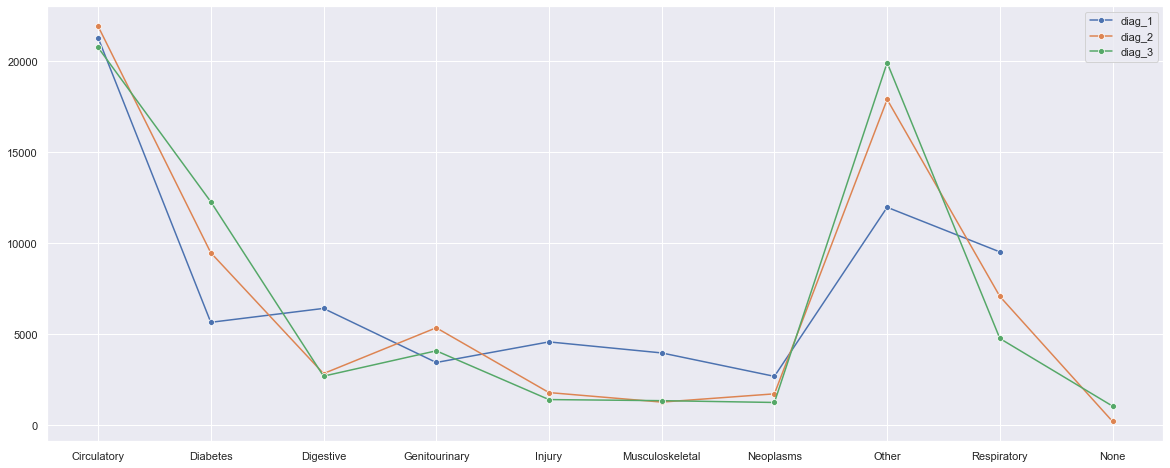

In [58]:
plt.figure(figsize=(20, 8))
for diag in ['diag_1','diag_2','diag_3']:
    sns.lineplot(x=df[diag].value_counts().sort_index().index, y= df[diag].value_counts().sort_index().values, marker='o')
plt.legend(['diag_1','diag_2','diag_3'])
plt.show()

* Looking at the graph above, we can say that there is a high correlation between the diagnoses. So we drop diag_2 and diag_3.
* Also since the most common diagnoses are prevalent in all three diagnoses listed, We are only using the primary diagnosis variable to build the machine learning model

In [59]:
# drop diagnoses 2 and 3
df = df.drop(columns=['diag_2', 'diag_3'])

### FOCUS ON "`number_diagnoses`"

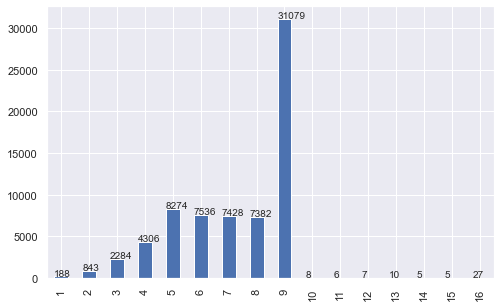

In [60]:
plt.figure(figsize=(8,5))
ax = df.number_diagnoses.value_counts().sort_index().plot.bar()
def labels(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.0f}'.format(p.get_height()), 
                        (p.get_x(), p.get_height()+100),size=10)
labels(ax)

* For a small number of observations with number of diagnoses greater than 9, let's change the number of diagnoses to 9.

In [61]:
df.number_diagnoses = df.number_diagnoses.replace([10,11,12,13,14,15,16],9)

### Outlier Detection

Based on the basic statistics describing the dataset, it looks there are outliers that influence skewness in the data. In order to represent the majority of samples and build clean models, we are going to remove outliers that have [z-scores](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) greater than 3.0 or less than -3.0. This means that we are removing samples that are more (or less) than 3 times the standard deviation from the mean.

In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,69388.0,4.291895,2.951166,1.0,2.0,3.0,6.0,14.0
num_lab_procedures,69388.0,43.051839,19.992895,1.0,31.0,44.0,57.0,132.0
num_procedures,69388.0,1.432265,1.758236,0.0,0.0,1.0,2.0,6.0
num_medications,69388.0,15.709676,8.303491,1.0,10.0,14.0,20.0,81.0
number_outpatient,69388.0,0.283954,1.079474,0.0,0.0,0.0,0.0,42.0
number_emergency,69388.0,0.105696,0.515331,0.0,0.0,0.0,0.0,42.0
number_inpatient,69388.0,0.179930,0.607700,0.0,0.0,0.0,0.0,12.0
number_diagnoses,69388.0,7.262221,1.976164,1.0,6.0,8.0,9.0,9.0


In [63]:
features = df.describe().columns

In [64]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f), whis = 2.5)
    plt.xlabel("ROOT SQUARE - IQR=2.5")

    plt.subplot(144)
    plt.boxplot(np.log(df[col_name]+0.1), whis = 2.5)
    plt.xlabel("LOGARITMIC - IQR=2.5")
    plt.show()

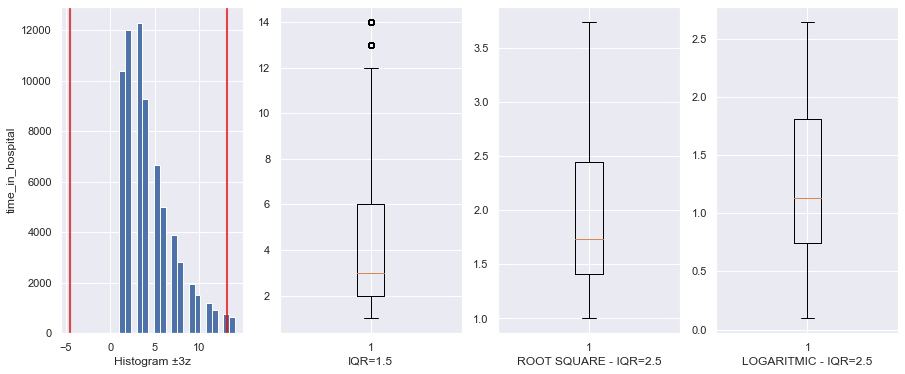

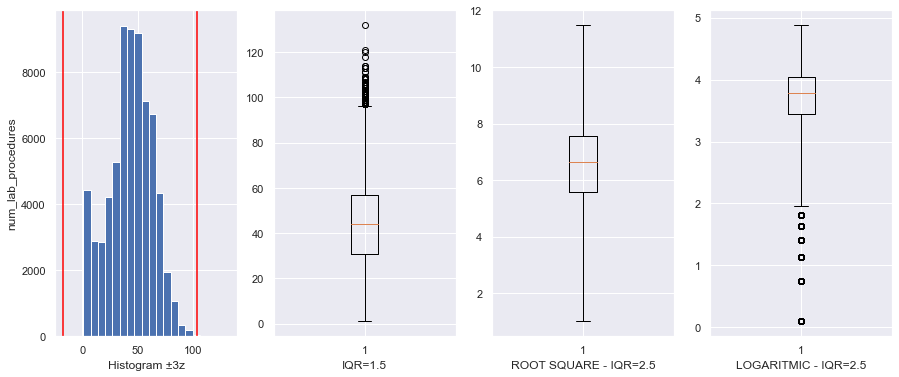

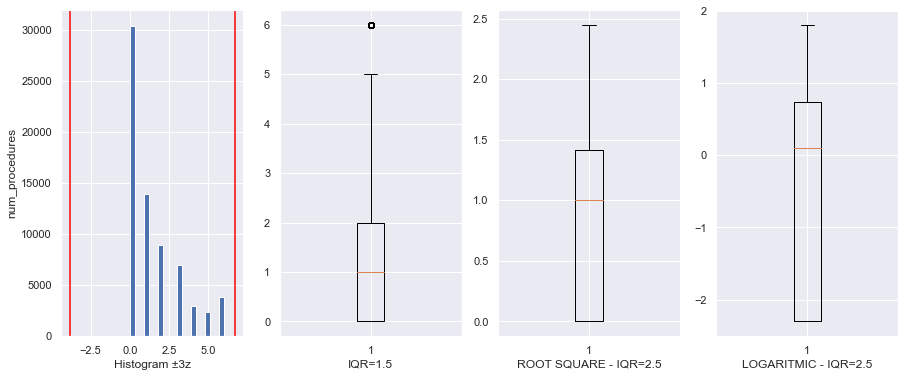

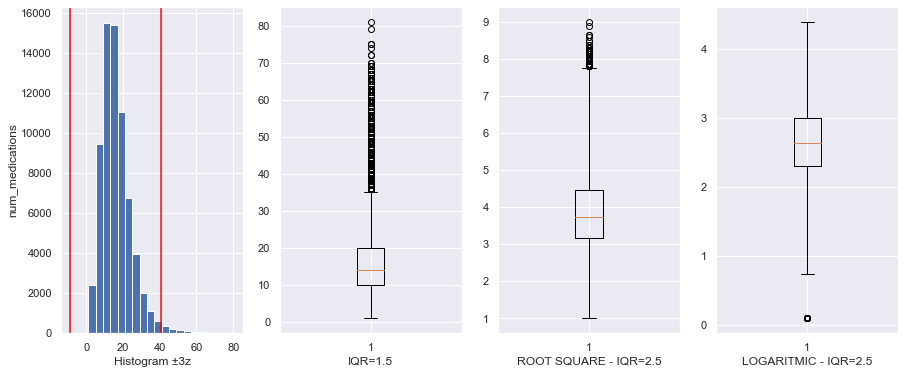

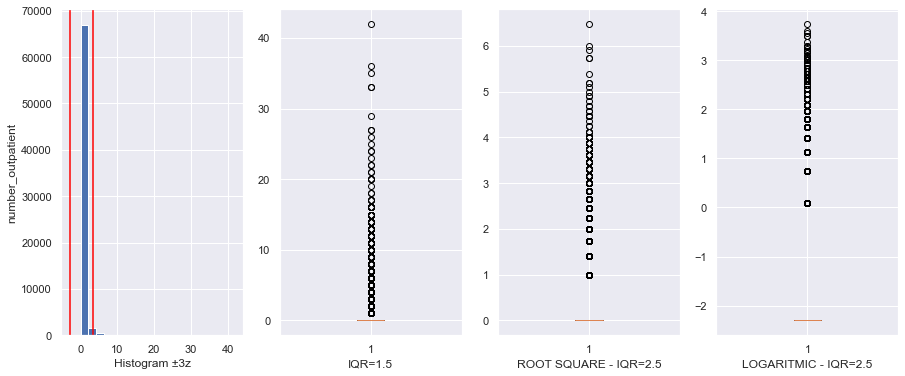

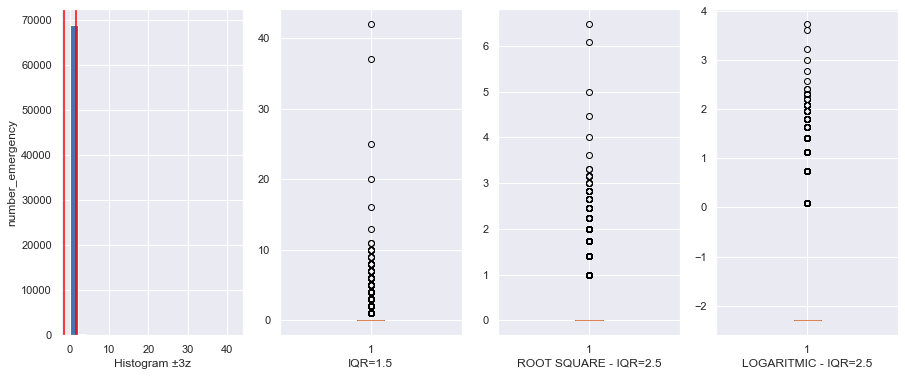

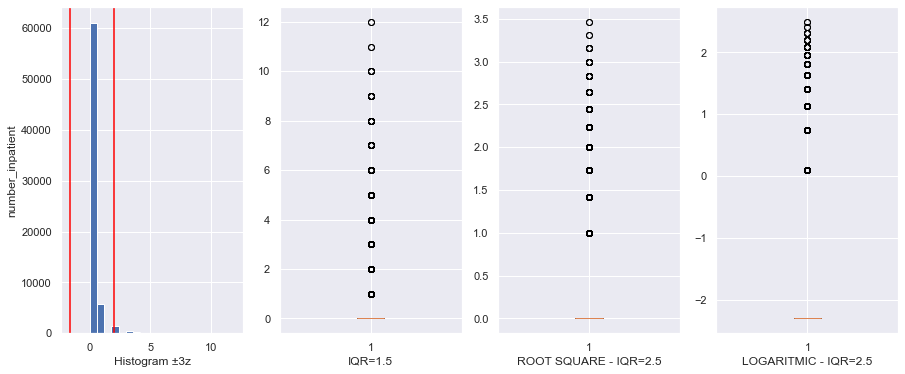

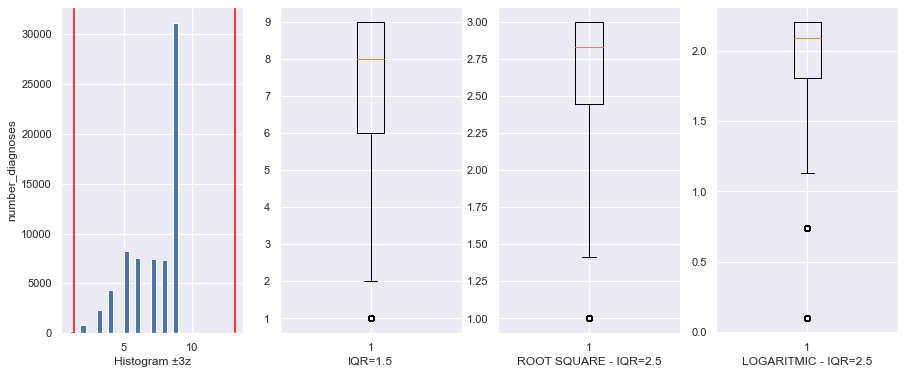

In [65]:
for i in features:
    col_plot(df,i)

In [66]:
from scipy.stats.mstats import winsorize

def plot_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    logr=np.log(df[col_name]+0.1)

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(logr, bins=22)
    plt.axvline(x=logr.mean()+3*logr.std(),color='red')
    plt.axvline(x=logr.mean()-3*logr.std(),color='red')
    plt.xlabel('Logr_col_name')

    plt.subplot(144)
    plt.boxplot(logr, whis = 1.5)
    plt.xlabel("Logaritmic - IQR=1.5")
    plt.show()    


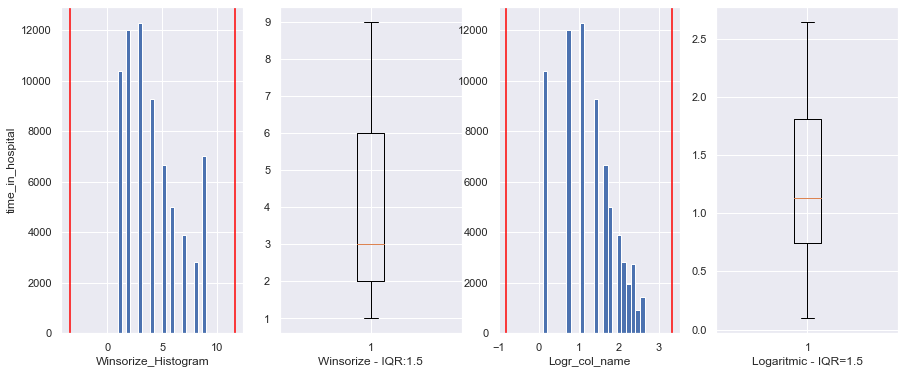

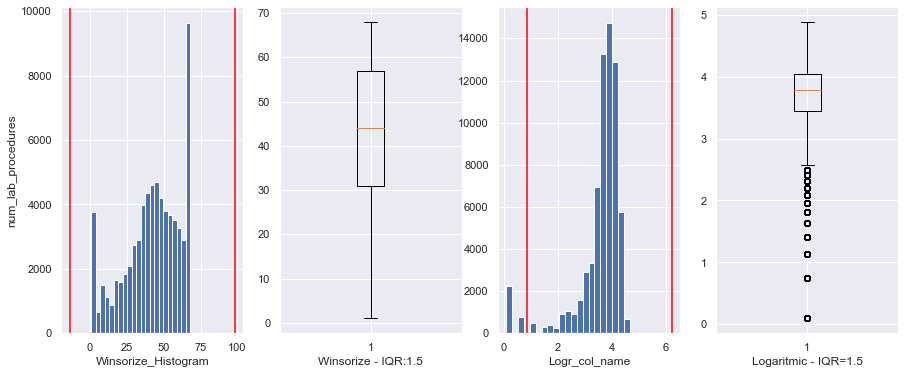

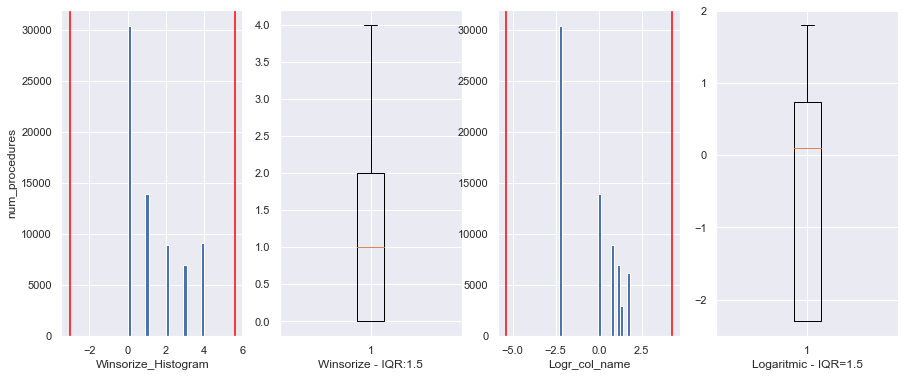

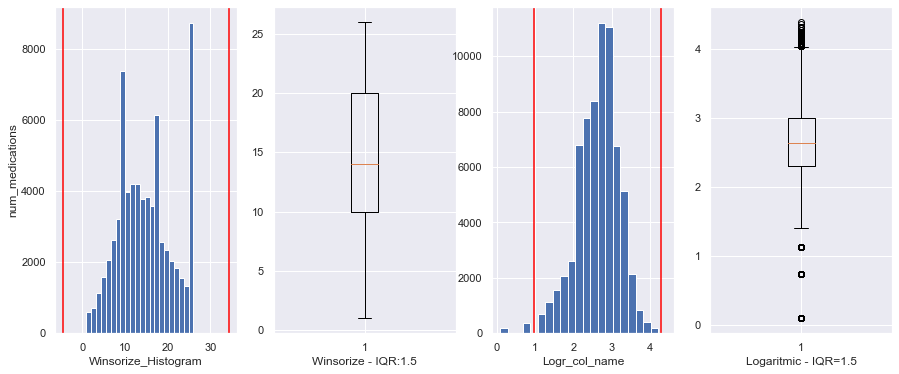

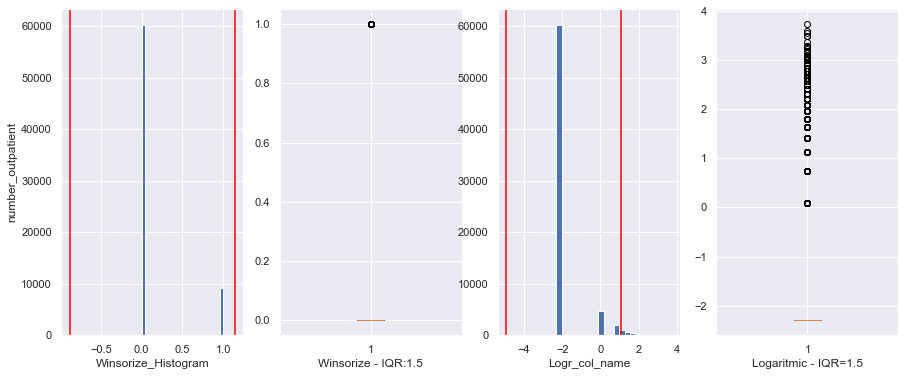

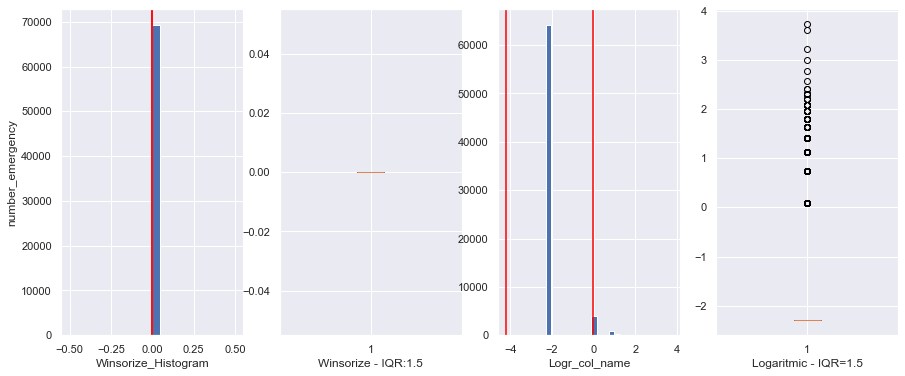

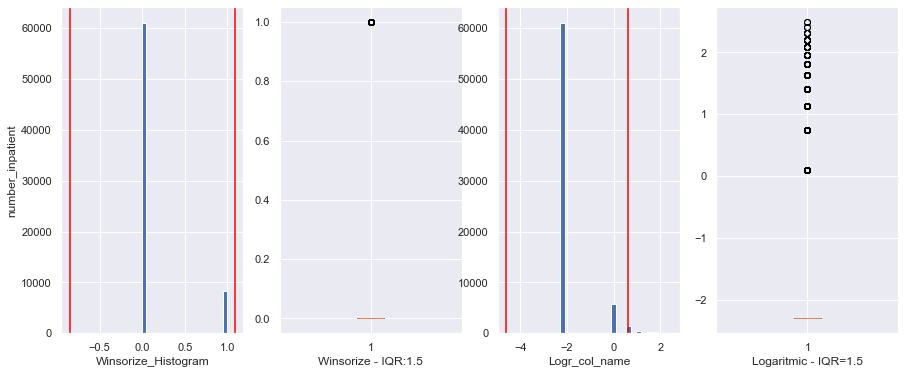

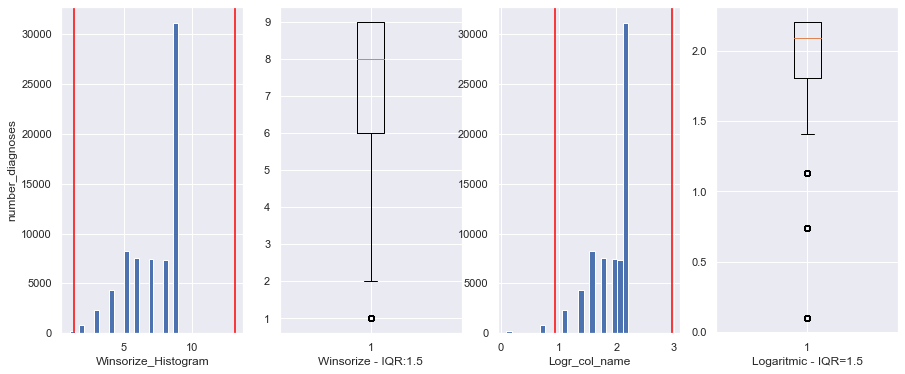

In [67]:
for i in features:
    plot_winsorize(df,i)

In [68]:
df_winsorised=df.copy()
for i in features:
    df_winsorised[i]=winsorize(df_winsorised[i], (0,0.1))

In [69]:
df_log=df.copy()
for i in features:
    df_log[i]=np.log(df_log[i])

In [70]:
df_root=df.copy()
f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
for i in features:
    df_root[i]=df_root[i].apply(f)

In [71]:
from numpy import percentile
from scipy.stats import zscore
from scipy import stats

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = zscore(df[col].dropna())
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile)

In [72]:
from scipy.stats import zscore
from scipy import stats

def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.5, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.distplot(df[col], kde=False, bins = 50)
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
   
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step)
    
    plt.subplot(1,3,1)
    plt.axvline(x=df[col].mean() + z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.axvline(x=df[col].mean() - z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.show()
    
    return z_score_inspect

In [73]:
def detect_outliers(df:pd.DataFrame, col_name:str, p=1.5) ->int:
    ''' 
    this function detects outliers based on 3 time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(p*IQR)
    lower_limit = first_quartile-(p*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [74]:
k=3
print(f"Number of Outliers for {k}*IQR\n")

total=0
for col in features:
    if detect_outliers(df, col)[2] > 0:
        outliers=detect_outliers(df, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

Number of Outliers for 3*IQR

0 outliers in 'time_in_hospital'
0 outliers in 'num_lab_procedures'
0 outliers in 'num_procedures'
342 outliers in 'num_medications'
9120 outliers in 'number_outpatient'
5148 outliers in 'number_emergency'
8274 outliers in 'number_inpatient'
0 outliers in 'number_diagnoses'

22884 OUTLIERS TOTALLY


In [75]:
k=3
print(f"Number of Outliers for {k}*IQR after Root Square\n")

total=0
for col in features:
    if detect_outliers(df_root, col)[2] > 0:
        outliers=detect_outliers(df_root, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

Number of Outliers for 3*IQR after Root Square

0 outliers in 'num_lab_procedures'
7 outliers in 'num_medications'
9120 outliers in 'number_outpatient'
5148 outliers in 'number_emergency'
8274 outliers in 'number_inpatient'
0 outliers in 'number_diagnoses'

22549 OUTLIERS TOTALLY


In [76]:
k=3
print(f"Number of Outliers for {k}*IQR after Winsorised\n")

total=0
for col in features:
    if detect_outliers(df_winsorised, col)[2] > 0:
        outliers=detect_outliers(df_winsorised, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

Number of Outliers for 3*IQR after Winsorised

9120 outliers in 'number_outpatient'
8274 outliers in 'number_inpatient'
0 outliers in 'number_diagnoses'

17394 OUTLIERS TOTALLY


In [77]:
k=3
print(f"Number of Outliers for {k}*IQR after Logarithmed\n")

total=0
for col in features:
    if detect_outliers(df_log, col)[2] > 0:
        outliers=detect_outliers(df_log, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

Number of Outliers for 3*IQR after Logarithmed

3774 outliers in 'num_lab_procedures'
205 outliers in 'num_medications'
188 outliers in 'number_diagnoses'

4167 OUTLIERS TOTALLY


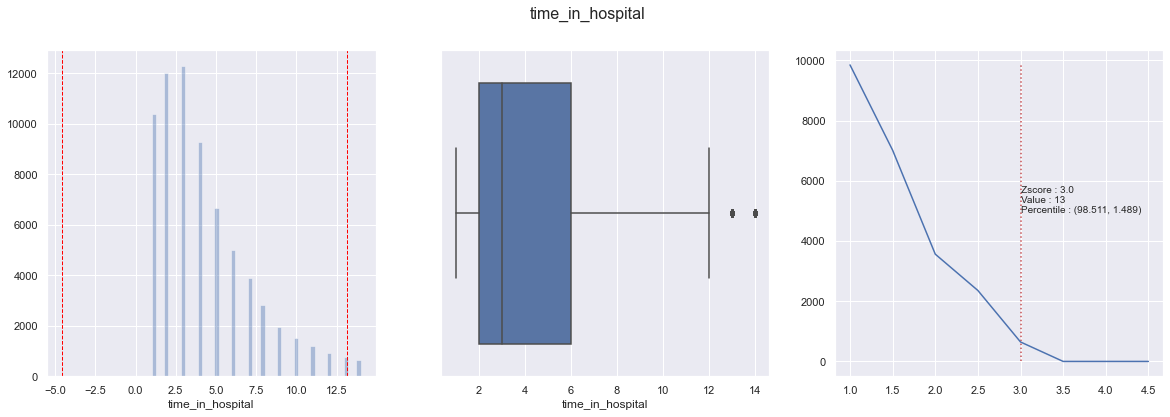

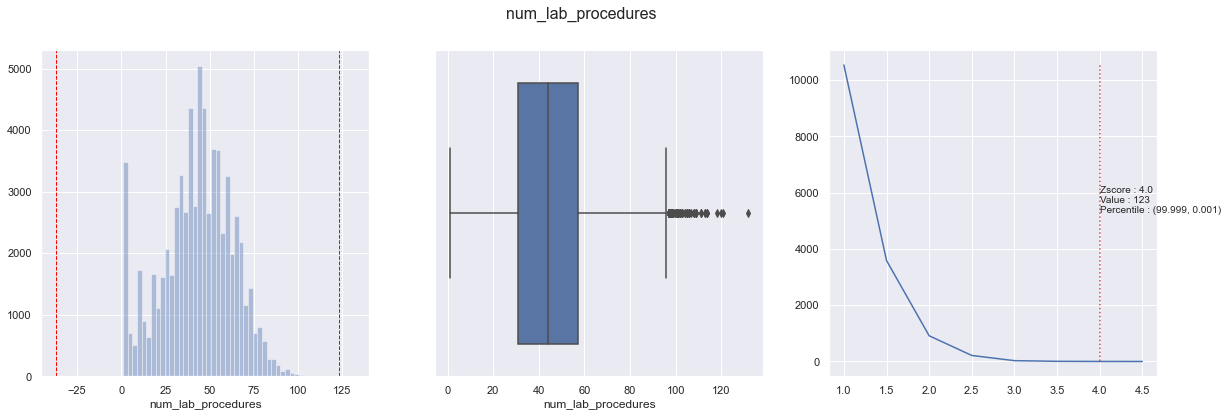

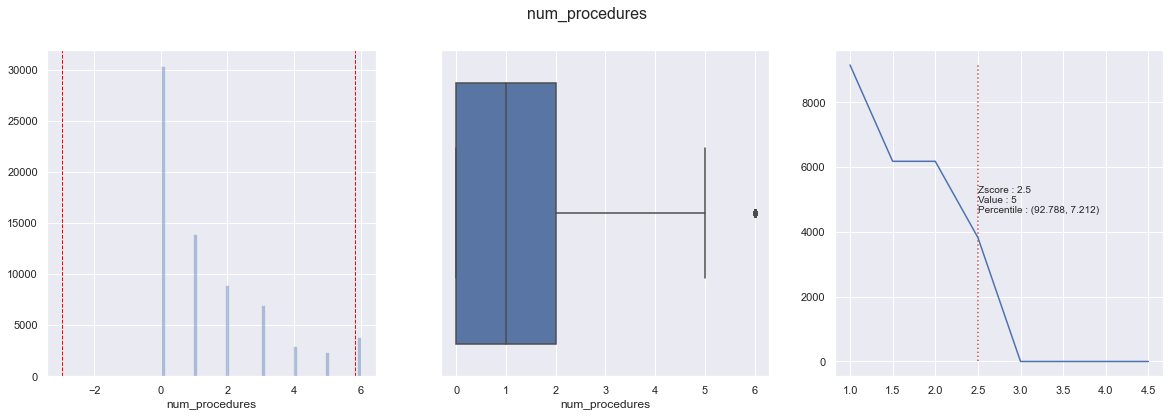

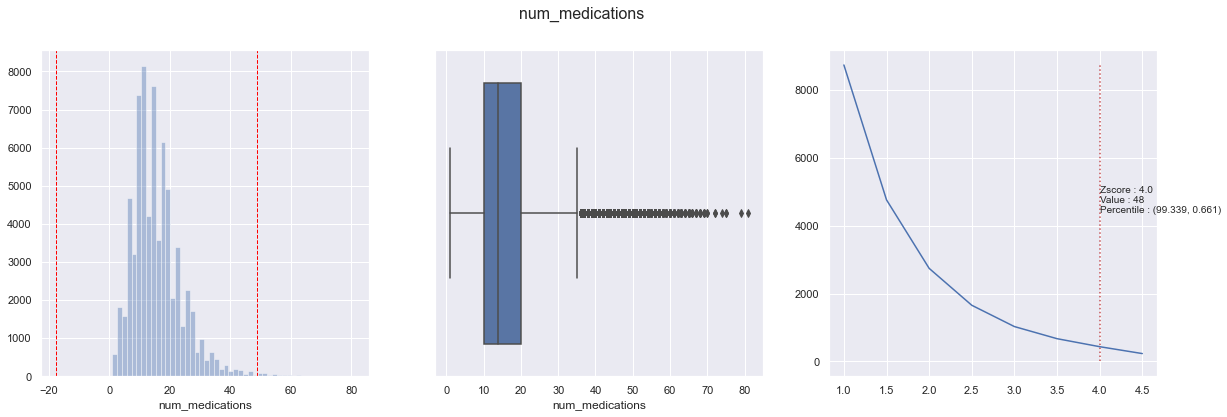

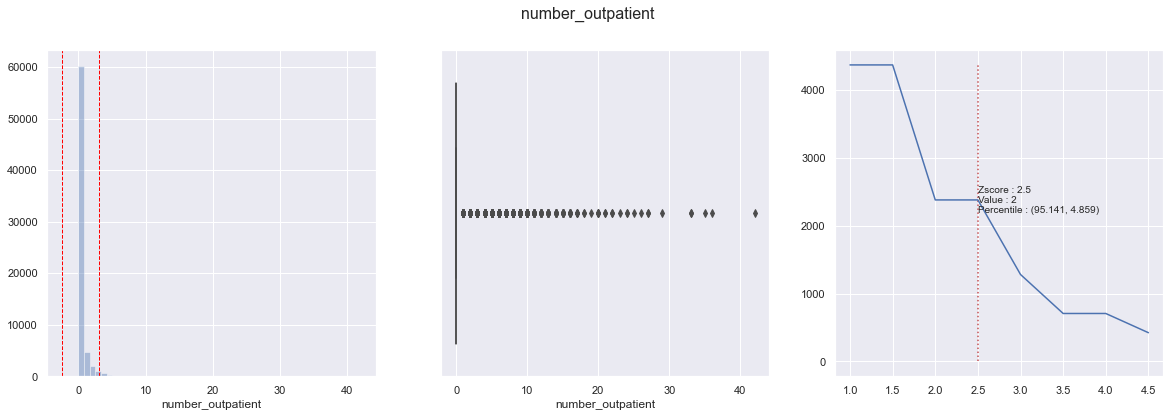

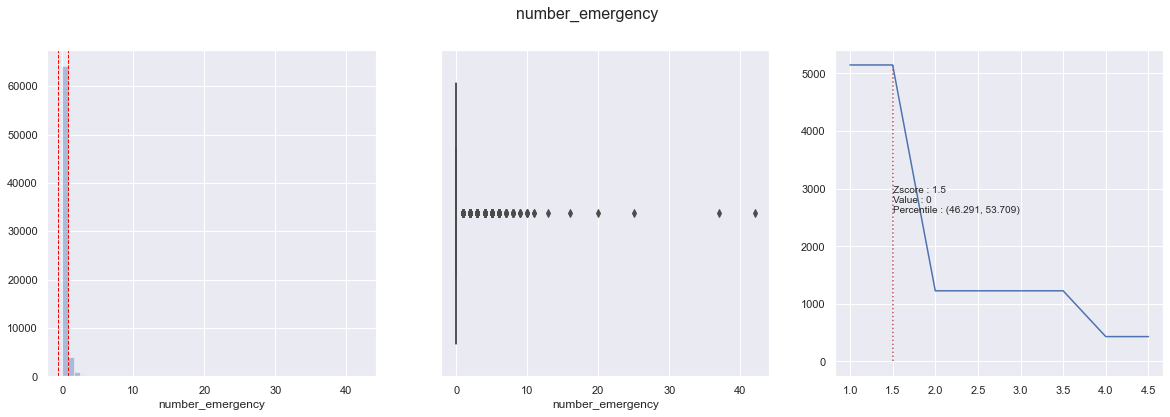

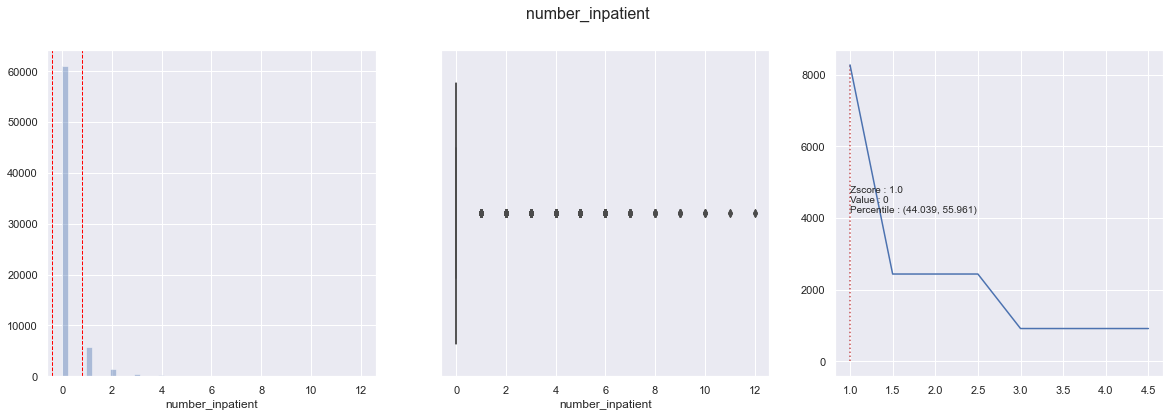

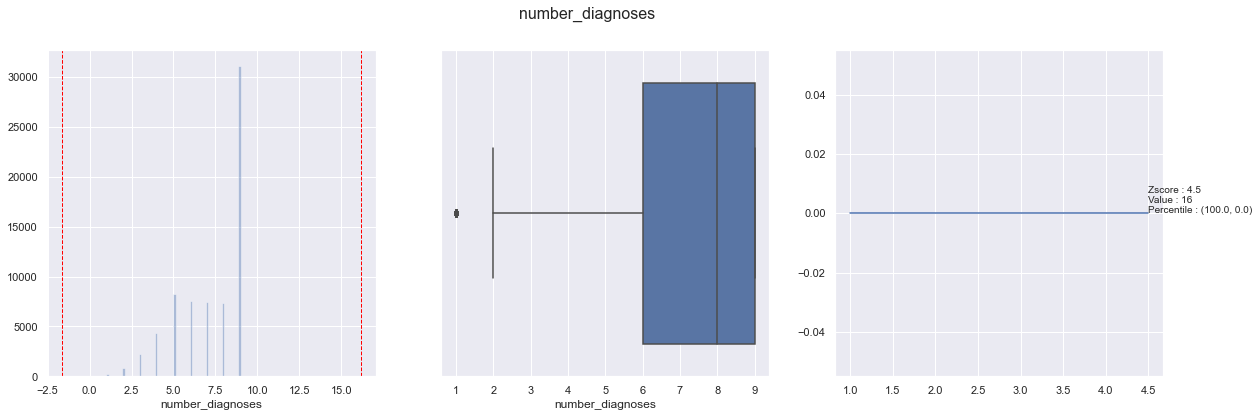

In [78]:
z_scores=[]
for i in features:
    z_scores.append(outlier_inspect(df,i)[2])

In [79]:
z_scores

[3.0, 4.0, 2.5, 4.0, 2.5, 1.5, 1.0, 4.5]

In [80]:
features

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')

In [81]:
# Alternative 1
# df_3z=df.copy()
# for i in features:
#     down_limit= df_3z[i].mean() - (3*df_3z[i].std())
#     upper_limit= df_3z[i].mean() + (3*df_3z[i].std())
#     condition= (df_3z[i] > down_limit) & (df_3z[i] < upper_limit)
#     df_3z=df_3z[condition]

# print('Number of Outliers:',len(df)-len(df_3z))

Number of Outliers: 6351


In [82]:
# Alternative 2

# create columns for z scores, new column with z score
df_3z=df.copy()

for x in features:
    df_3z[x + '_z'] = stats.zscore(df_3z[x])

for x in df_3z.columns[-len(features):]:
    df_3z = df_3z[(df_3z[x] < 3) & (df_3z[x] > -3)]
    
# drop _z columns
df_3z = df_3z.drop(columns=df_3z.columns[-8:])

print('Number of Outliers:',len(df)-len(df_3z))

Number of Outliers: 4993


In [83]:
df_3z.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,64395.0,4.14,2.77,1.0,2.0,3.0,6.0,13.0
num_lab_procedures,64395.0,42.53,19.84,1.0,30.0,44.0,57.0,103.0
num_procedures,64395.0,1.39,1.72,0.0,0.0,1.0,2.0,6.0
num_medications,64395.0,15.11,7.20,1.0,10.0,14.0,19.0,40.0
number_outpatient,64395.0,0.17,0.54,0.0,0.0,0.0,0.0,3.0
number_emergency,64395.0,0.06,0.23,0.0,0.0,0.0,0.0,1.0
number_inpatient,64395.0,0.12,0.39,0.0,0.0,0.0,0.0,2.0
number_diagnoses,64395.0,7.23,1.97,2.0,6.0,8.0,9.0,9.0


In [84]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,69388.0,4.29,2.95,1.0,2.0,3.0,6.0,14.0
num_lab_procedures,69388.0,43.05,19.99,1.0,31.0,44.0,57.0,132.0
num_procedures,69388.0,1.43,1.76,0.0,0.0,1.0,2.0,6.0
num_medications,69388.0,15.71,8.30,1.0,10.0,14.0,20.0,81.0
number_outpatient,69388.0,0.28,1.08,0.0,0.0,0.0,0.0,42.0
number_emergency,69388.0,0.11,0.52,0.0,0.0,0.0,0.0,42.0
number_inpatient,69388.0,0.18,0.61,0.0,0.0,0.0,0.0,12.0
number_diagnoses,69388.0,7.26,1.98,1.0,6.0,8.0,9.0,9.0


### Check Unique Values

Investigate the unique values of each column and look for error entries.

In [85]:
summary(df_3z)

Data shape: (64395, 38)
___________________________
Data Types:
object    30
int64      8
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
A1Cresult,object,64395,4,0,>7,Norm
acarbose,object,64395,3,0,No,Up
acetohexamide,object,64395,1,0,No,No
age,object,64395,10,0,[0-10),[90-100)
change,object,64395,2,0,Ch,No
chlorpropamide,object,64395,4,0,Down,Up
diabetesMed,object,64395,2,0,No,Yes
diag_1,object,64395,9,0,Circulatory,Respiratory
gender,object,64395,2,0,Female,Male
glimepiride,object,64395,4,0,Down,Up


> Drop the columns that the number of uniques is 1

In [86]:
df_3z = df_3z.drop(['acetohexamide','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1)

### Export Cleaned Dataset

In [87]:
df_3z = df_3z.reset_index(drop=True)
df_3z.to_csv('diabetic_data_cleaned.csv')